# Depression and Anxiety Indicator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statsmodels.api as sm
import patsy
import sklearn.linear_model
import sklearn.ensemble
import sklearn.neural_network
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
sns.set(rc={"figure.figsize":(12, 8)})

# Data Cleaning

Steps:

We will start by renaming the column we need based on the codebook which is available [here](https://www.cdc.gov/nchs/nhis/2020nhis.htm).

Then, we replace the value 5 in anxiety and depression frequency to 0
These columns are how often the person feel worried, nervous, or anxious
1-4 are range in “Daily”, “Weekly”, “Monthly”, “A few times in a year”
5 in both anxiety and depression frequency means **never** experiencing the problem.

Replace NAN in anxiety and depression level with 0
1-3 are range in “A little”, “A lot”, “Somewhere in between a little and a lot”.
Removing rows of ambiguous samples with responses, “I don’t know”, “not ascertained”, and “refused”, from the rest of dataset
Encode all binary responses to 1/0 instead of 1/2 for yes/no.
Reduce the number of categories for the education column to 3 because it had too many details.
After this brief cleaning, there are 29046 samples left from the original dataset with 31569 samples.

In [4]:
adult_df = pd.read_csv('adult20.csv')

In [5]:
need_cols = ['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A',
             'NOTCOV_A', 'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A','DEPLEVEL_A',
             'ORIENT_A', 'MARITAL_A', 'INCGRP_A', 'BMICAT_A']

In [6]:
subset_df = adult_df[need_cols]

In [7]:
subset_df.columns

Index(['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A', 'NOTCOV_A',
       'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPLEVEL_A', 'ORIENT_A',
       'MARITAL_A', 'INCGRP_A', 'BMICAT_A'],
      dtype='object')

In [8]:
subset_df.columns = ['urbanrural', 'age', 'sex', 'edu', 'anx_ever', 'dep_ever', 
                    'inscov', 'anx_freq', 'anx_level', 'dep_freq', 'dep_level', 
                    'orient', 'marital', 'income', 'bmi']

In [9]:
column_map = dict(zip(subset_df.columns, need_cols))

In [10]:
subset_df = subset_df.replace({"anx_freq": {5: 0}, "dep_freq": {5: 0}})

In [11]:
subset_df.isna().any()

urbanrural    False
age           False
sex           False
edu           False
anx_ever      False
dep_ever      False
inscov        False
anx_freq      False
anx_level      True
dep_freq      False
dep_level      True
orient        False
marital       False
income        False
bmi           False
dtype: bool

In [12]:
subset_df.loc[:, 'anx_level'] = subset_df.loc[:, 'anx_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [13]:
subset_df.loc[:, 'dep_level'] = subset_df.loc[:, 'dep_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [14]:
subset_df['anx_level'].value_counts()

1.0    11069
0.0     9676
3.0     8304
2.0     2380
9.0       83
7.0       51
8.0        5
Name: anx_level, dtype: int64

We will remove value 7, 8, 9 as it reprents 'Refused', 'Not Ascertained', 'Don't Know' which does not account to the problem we are trying to solve.

In [15]:
subset_df = subset_df[(subset_df['anx_level'] < 7.0) & (subset_df['dep_level'] < 7.0)]
subset_df = subset_df[(subset_df['anx_freq'] < 7.0) & (subset_df['dep_freq'] < 7.0)]
# less than 1% of the sample is removed.

In [16]:
column_map

{'urbanrural': 'URBRRL',
 'age': 'AGEP_A',
 'sex': 'SEX_A',
 'edu': 'EDUC_A',
 'anx_ever': 'ANXEV_A',
 'dep_ever': 'DEPEV_A',
 'inscov': 'NOTCOV_A',
 'anx_freq': 'ANXFREQ_A',
 'anx_level': 'ANXLEVEL_A',
 'dep_freq': 'DEPFREQ_A',
 'dep_level': 'DEPLEVEL_A',
 'orient': 'ORIENT_A',
 'marital': 'MARITAL_A',
 'income': 'INCGRP_A',
 'bmi': 'BMICAT_A'}

In [17]:
subset_df = subset_df[(subset_df['sex'] <= 2) & (subset_df['edu'] <= 11) & 
          (subset_df['age'] <= 85) & (subset_df['anx_ever'] <= 2) & (subset_df['dep_ever'] <= 2) & 
          (subset_df['inscov'] <= 2) & (subset_df['orient'] <= 4) & (subset_df['marital'] <= 3) &
          (subset_df['bmi'] <= 4)]

In [18]:
def map_edu(x):
    if x in {0, 1, 2, 3, 4, 5}:
        return 1
    elif x in {6, 7, 8}:
        return 2
    return 3

In [19]:
subset_df['edu'] = subset_df['edu'].apply(map_edu)

In [20]:
subset_df['anx_ever'] = subset_df['anx_ever'].apply(lambda x : 0 if (x == 2) else x)

In [21]:
subset_df['dep_ever'] = subset_df['dep_ever'].apply(lambda x : 0 if (x == 2) else x)

# Creating the depression score column
**Score = anx_level x anx_freq + dep_level x dep_freq**

In [22]:
subset_df.shape

(29046, 15)

In [23]:
subset_df.head()

,urbanrural,age,sex,edu,anx_ever,dep_ever,inscov,anx_freq,anx_level,dep_freq,dep_level,orient,marital,income,bmi
0,3,85,1,1,0,0,2,0,0.0,0,0.0,2,1,5,2
1,3,39,1,1,0,0,2,4,1.0,0,0.0,2,3,4,4
2,3,42,1,1,0,0,2,0,0.0,0,0.0,2,3,4,2
3,3,32,1,2,0,0,2,3,1.0,0,0.0,2,2,3,2
4,3,85,2,1,0,1,2,0,0.0,2,1.0,2,3,1,3


In [24]:
def mh_score(row):
    return row['anx_level'] * row['anx_freq'] + row['dep_level'] * row['dep_freq']

In [25]:
subset_df['score'] = subset_df.apply(mh_score, axis=1)

In [26]:
score_col = subset_df['score'] 

Text(0.5, 1.0, 'Frequency Distribution of Depression Score')

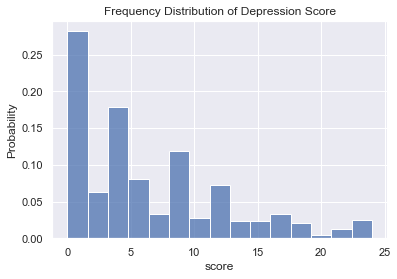

In [27]:
sns.histplot(data=subset_df, x='score', stat="probability", bins=15)
plt.title("Frequency Distribution of Depression Score")

Since the score column is skewed, we use sklearn's standard scaler to normalize it and store in another column

In [28]:
# create new column using standard scaler
subset_df['norm_score'] = sklearn.preprocessing.StandardScaler().fit_transform(subset_df['score'].to_numpy().reshape(-1,1))

Text(0.5, 1.0, 'Frequency Distribution of Normalized Depression Score')

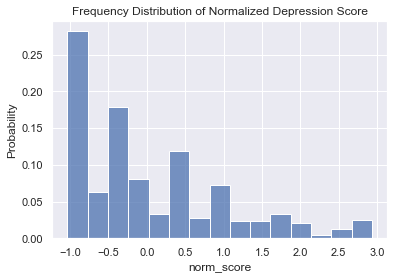

In [29]:
sns.histplot(data=subset_df, x='norm_score', stat="probability", bins=15)
plt.title("Frequency Distribution of Normalized Depression Score")

We will form a binary variable indicating that if a sample has > 0 depression score, so that we can frame our problem as both regression and classfication problem.

In [30]:
subset_df['mh_ever'] = subset_df['score'].apply(lambda x : x > 0)

Text(0.5, 1.0, 'Ever Had Mental Health Issues')

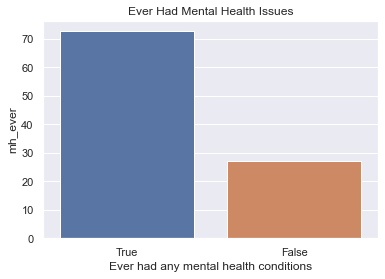

In [31]:
sns.barplot(x="mh_ever", y="mh_ever", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, order=[True, False])
plt.xlabel('Ever had any mental health conditions')
plt.title('Ever Had Mental Health Issues')

We can conclude that more samples have reported at least experiencing some sort of mental health issue.

# Data Analysis & Results
# EDA

In [32]:
subset_df.columns

Index(['urbanrural', 'age', 'sex', 'edu', 'anx_ever', 'dep_ever', 'inscov',
       'anx_freq', 'anx_level', 'dep_freq', 'dep_level', 'orient', 'marital',
       'income', 'bmi', 'score', 'norm_score', 'mh_ever'],
      dtype='object')

In [33]:
subset_df.head()

,urbanrural,age,sex,edu,anx_ever,dep_ever,inscov,anx_freq,anx_level,dep_freq,dep_level,orient,marital,income,bmi,score,norm_score,mh_ever
0,3,85,1,1,0,0,2,0,0.0,0,0.0,2,1,5,2,0.0,-1.034039,False
1,3,39,1,1,0,0,2,4,1.0,0,0.0,2,3,4,4,4.0,-0.373319,True
2,3,42,1,1,0,0,2,0,0.0,0,0.0,2,3,4,2,0.0,-1.034039,False
3,3,32,1,2,0,0,2,3,1.0,0,0.0,2,2,3,2,3.0,-0.538499,True
4,3,85,2,1,0,1,2,0,0.0,2,1.0,2,3,1,3,2.0,-0.703679,True


# Depression Score

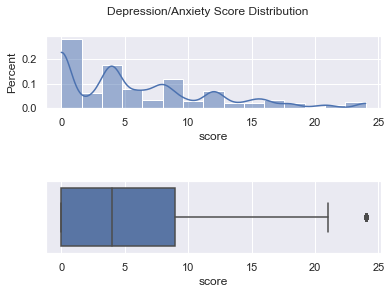

In [34]:
fig, axes = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1, wspace=1)
sns.histplot(data=subset_df, x='score', bins=15, kde=True, ax = axes[0], stat="probability").set_ylabel('Percent')
plt.suptitle('Depression/Anxiety Score Distribution')
sns.boxplot(data=subset_df, x='score', ax = axes[1])
fig.show()

**Distribution is severely right-skewed, which means majority of samples in the dataset has no mental health issues**

In [35]:
def get_outliers(col):
    IQR = col.quantile(q=0.75) - col.quantile(q=0.25)
    return col[np.abs(col - col.mean()) > 1.5 * IQR]

In [36]:
get_outliers(subset_df['score'])

13       20.0
33       24.0
42       20.0
60       24.0
73       24.0
         ... 
31508    24.0
31527    21.0
31534    24.0
31537    24.0
31558    24.0
Name: score, Length: 1228, dtype: float64

There are 1261 outliers in the 'score' column according to the 1.5*IQR rule, most of our samples are concentrated in the 0-20 range.
So, we will decide to consider any sample with > 20 score as an outlier.

# Age

Text(0.5, 1.0, 'Age Distribution')

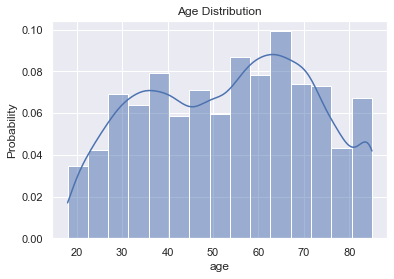

In [37]:
ax = sns.histplot(x = 'age', data = subset_df, stat="probability", bins = 15, kde=True)
ax.set_title('Age Distribution')

The Age Distrubution is approximately a uniform distribution

In [38]:
get_outliers(subset_df['age'])

Series([], Name: age, dtype: int64)

Using the  **1.5*IQR**  rule, the 'age' column does not seem to have any outliers.

# Regional Information
### Category: Urban or Rural
Code:
1. -->Large central metro 
2. -->Large fringe metro 
3. -->Medium and small metro 
4. -->Nonmetropolitan

Text(0.5, 1.0, 'Urban/Rural Breakdown')

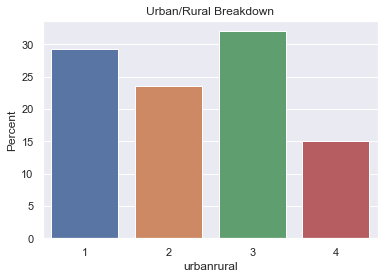

In [39]:
ax = sns.barplot(x="urbanrural", y="urbanrural", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Urban/Rural Breakdown')

From the barplot, we can point out that most samples live in metro areas, while nonmetropolitan group is the minority. This could be a potential factor because the lifestyle in urban areas is significantly different compared to the lifestyle in rural areas. 

# Gender
### Category: Male or Female
Code:
* 1 --> Male
* 2 --> Female

Text(0.5, 1.0, 'Gender Breakdown')

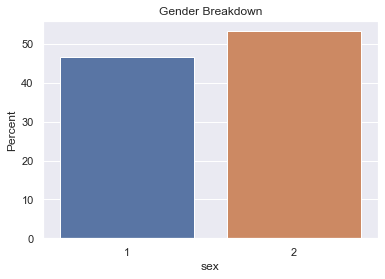

In [40]:
ax = sns.barplot(x="sex", y="sex", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Gender Breakdown')

Around 47% of the survey response is **Male**, while 53% is from **Female**

# Education Level
### Category: Below Degree, Degree, Above Degree
Code:
* 1 --> Below Degree
* 2 --> Bachelor's Degree
* 3 --> Above Degree (Masters, PhD)

Text(0.5, 1.0, 'Education Level Breakdown')

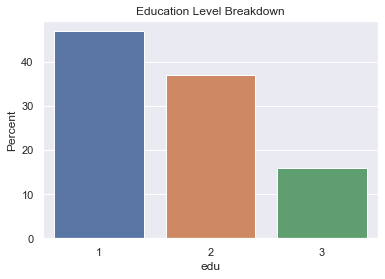

In [41]:
ax = sns.barplot(x="edu", y="edu", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Education Level Breakdown')

From the barplot above, we can observe that 'Below Degree' group is the most frequent category at about 48%, with 'Bachelor's Degree's ranked second at around 37%. While 'Above Degree' group is the minority in our dataset standing at roughly 15%.

# Anxiety Level and Depression Level
### Category: no anxiety, A little, A lot, Somewhere in between a little and a lot
Code:
* 0 --> no anxiety
* 1 --> A little
* 2 --> A lot
* 3 --> Somewhere in between a little and a lot

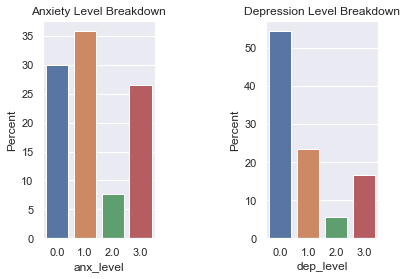

In [42]:
fig, axes =plt.subplots(1,2)
fig.subplots_adjust(hspace=1, wspace=1)
sns.barplot(x="anx_level", y="anx_level", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Level Breakdown')
sns.barplot(x="dep_level", y="dep_level", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Level Breakdown')
fig.show()

In both graphs, most people show little or no anixety/depression. However, from the Anxiety Level Breakdown plot, participants tend to be more anxious than depressesd.

# Anxiety Frequency and Depression Frequency
### Category: never, A few times a year, Monthly, Weekly, Daily
Code: 
* 0 ---> never
* 1 ---> A few times a year
* 2 ---> Monthly
* 3 ---> Weekly
* 4 ---> Daily

We will remove value 7, 8, 9 as it reprents 'Refused', 'Not Ascertained', 'Don't Know' which does not account to the problem we are trying to solve.

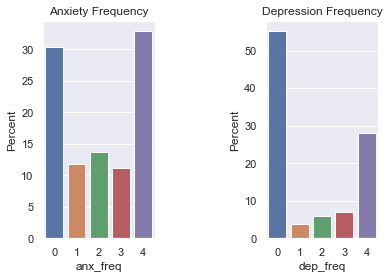

In [43]:
fig, axes =plt.subplots(1,2)
fig.subplots_adjust(hspace=1, wspace=1)

sns.barplot(x="anx_freq", y="anx_freq", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Frequency')
sns.barplot(x="dep_freq", y="dep_freq", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Frequency')
fig.show()

From the plots, we can deduce that majority of the  participants does not experience anxiety or depression. Instead, there are more people reportedly feeling anxious when compared to those who are feeling depressed. Anxiety Frequency plot is a bimodal distribution, while Depresion Frequency plot is also slight considered a bimodal distribution and slightly right-skewed.

# Insurance Coverage
### Category: Covered or Not Covered
Code:
* 1 ---> not covered
* 2 ---> covered

Text(0.5, 1.0, 'Medical Insurance Coverage')

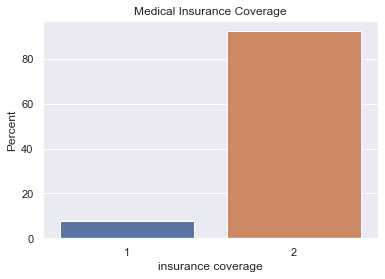

In [44]:
ax_ins = sns.barplot(x="inscov", y="inscov", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_ins.set(ylabel="Percent", xlabel = 'insurance coverage')
ax_ins.set_title('Medical Insurance Coverage')

From the plot, it is clear that vast majority of samples have insurance covered. Thus, it might be a huge factor on why there are less samples having anxiety or depression.

# Sexual Orientation
### Cateogry: Gay/Lesbian, Straight, Bisexual, Something else
Code:
* 1 ---> Gay/Lesbian
* 2 ---> Straight
* 3 ---> Bisexual
* 4 ---> Something else

Text(0.5, 1.0, 'Sexual Orientation Breakdown')

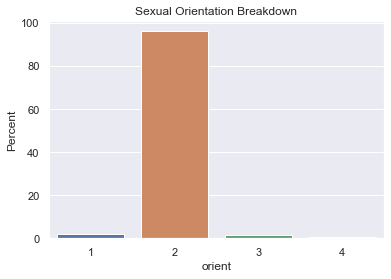

In [45]:
ax = sns.barplot(x="orient", y="orient", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Sexual Orientation Breakdown')

From the plot, we can observe that more than 90% of samples are straight, LGBTQ individuals are higher risk of experiencing poor mental health. According to [source](https://www.mentalhealth.org.uk/statistics/mental-health-statistics-lgbtiq-people). 

# Marital
### Category: Married, Living with partner together as unmarried couple, Neither
Code:
* 1 ---> married
* 2 ---> living with partner together as unmarried couple
* 3 ---> Neither

Text(0.5, 1.0, 'Marital Status Breakdown')

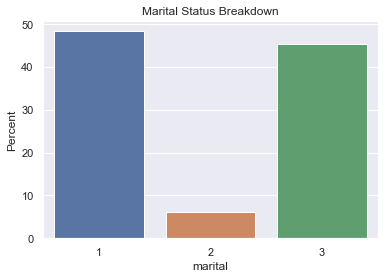

In [46]:
ax_marital = sns.barplot(x="marital", y="marital", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_marital.set(ylabel="Percent")
ax_marital.set_title('Marital Status Breakdown')

From the plot, married category is almost equal to neither(single/divorced) category. Based on [sources](https://www.sciencedirect.com/science/article/pii/S2352827321000495), being single and being divorced were found to be risk factors for depressive symptoms and lower self-esteem.

# Income
### Discription: adult family income (grouped)
Code:
* 1 --> $0 to 34,999

* 2 --> $35,000 to 49,999

* 3 --> $50,000 to 74,999

* 4 --> $75,000 to 99,999

* 5 --> $100,000 or greater

Text(0.5, 1.0, 'Household Income Breakdown')

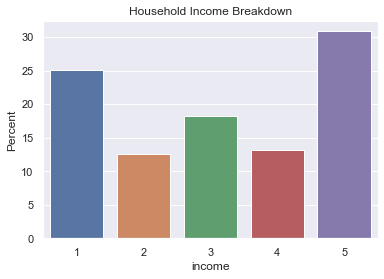

In [47]:
ax_income = sns.barplot(x="income", y="income", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_income.set(ylabel="Percent")
ax_income.set_title('Household Income Breakdown')

Income should be a bigger factor contibuting to mental health of individuals, the plot above represents a bimodal distribution, with majority of the percentages gathered in the poorest and richest group of families. 

# BMI
### Category : Underweight, Healthy weight, Overweight, Obese
Code: 
* 1-->Underweight
* 2-->Healthy weight
* 3-->Overweight
* 4-->Obese

Text(0.5, 1.0, 'BMI Breakdown')

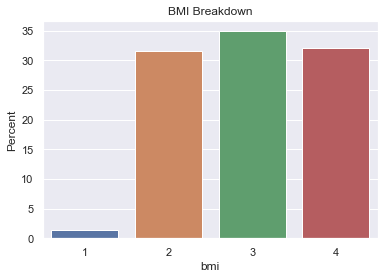

In [48]:
ax_bmi = sns.barplot(x="bmi", y="bmi", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_bmi.set(ylabel="Percent")
ax_bmi.set_title('BMI Breakdown')

From the graph, we can deduce that a vast majority of samples are either overweight or obese, thus indicating a major problem in the dataset we are using.
Based on the [source](https://www.goodrx.com/well-being/healthy-mind/obesity-and-mental-health), obesity is linked to mood and anxiety disorders.

# Relationship between Variables and Depression Score

### Correlation coefficient for Depression Score

In [49]:
subset_df.corr()['score']

urbanrural   -0.008825
age          -0.106128
sex           0.120152
edu           0.034687
anx_ever      0.185216
dep_ever      0.245932
inscov       -0.009074
anx_freq      0.572810
anx_level     0.775975
dep_freq      0.694935
dep_level     0.747250
orient        0.013664
marital       0.052902
income       -0.024318
bmi           0.013394
score         1.000000
norm_score    1.000000
mh_ever       0.633402
Name: score, dtype: float64

### Relationship between Income and Depression Score

In [50]:
income_score = subset_df[['income', 'score']].copy()
income_score.corr()

,income,score
income,1.000000,-0.024318
score,-0.024318,1.000000


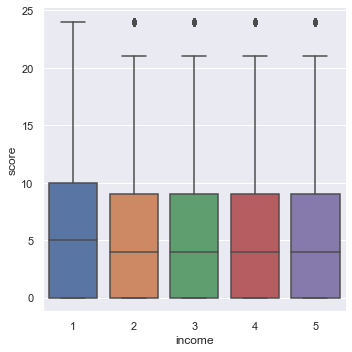

In [51]:

sns.catplot(x="income", y="score", kind="box", data=subset_df)

From the boxplot above, we can observe that lower income group tend to have higher depression score and as income increase, lesser samples have higher mental risks. Boxplot from 2 to 5 have similar meidan indicating that they have similar depression score distribution in the lower 50 percentile

### Relationship between BMI and Depression Score

In [52]:
bmi_dep = subset_df[['bmi', 'score']].copy()
bmi_dep.corr()

,bmi,score
bmi,1.000000,0.013394
score,0.013394,1.000000


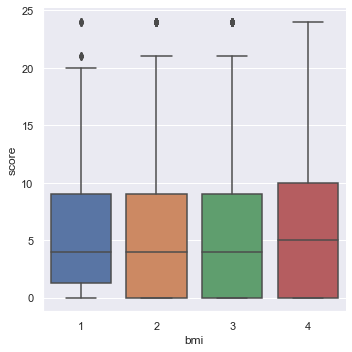

In [53]:
sns.catplot(x="bmi", y="score", kind="box", data=subset_df)

From the boxplots above, samples that are obese have have higer depression score, which is logical.

### Relationship between Gender and Depression Score

In [54]:
male_mh_score = subset_df[subset_df['sex'] == 1]['score']
female_mh_score = subset_df[subset_df['sex'] == 2]['score']

Text(0.5, 1.0, 'Depression score by gender')

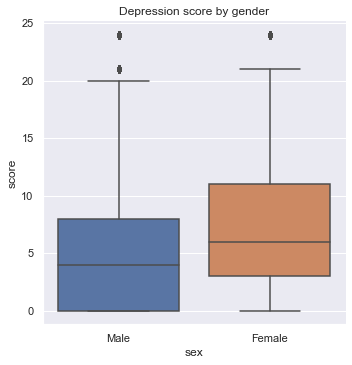

In [55]:
sns.catplot(kind='box', x='sex',y='score',data=subset_df)
ax = plt.gca()
ax.set_xticklabels(labels=['Male','Female'])
plt.title('Depression score by gender')

The above boxplot indicates that Female samples have a higher depression score compared to male samples, this is logical and somewhat accurate based on the [source](https://www.apa.org/news/press/releases/2011/08/mental-illness).
To find find out whether there is a significant difference statiscally, we will use an independent samples t test.

In [56]:
sm.stats.ttest_ind(male_mh_score, female_mh_score, alternative='smaller')

(-20.62606235518034, 3.773832518080606e-94, 29044.0)

With a p value in the order of 10e-94, we can see that the difference between male and female depression score is significant. Females generally have worse mental conditions than males.

### Relationships between Sexual Orientation and Depression Score

Since we have 4 category for Sexual Orientation (Gay/Lesbian, Straight, Bisexual, Something else). We will sort them with a new column 'LGBTQ' into binary varaible: LGBTQ or Non-LBGTQ.

In [57]:
LGBTQ_score = subset_df[subset_df['orient'] != 2]['score']
non_LGBTQ_score = subset_df[subset_df['orient'] == 2]['score']

In [58]:
# create new binary variable based on LGBTQ or straight
subset_df['lgbt'] = subset_df['orient'].apply(lambda x : 1 if x != 2 else 0)

Text(0.5, 1.0, 'Depression Score by Sexual Orientation')

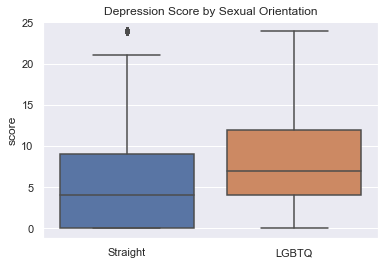

In [59]:
# A boxplot between LGBTQ and Depression Score
sns.boxplot(x='lgbt', y='score', data=subset_df)
ax = plt.gca()
ax.set_xticklabels(['Straight', 'LGBTQ'])
ax.set_xlabel('')
plt.title("Depression Score by Sexual Orientation")

From the boxplot, we can observe that the LGBTQ group have higher depression score(higher median, 25 percentile, 75 percentile) compared to Stright group
We will use independent t test again to find out the statistical difference.

In [60]:
t, p, dof = sm.stats.ttest_ind(LGBTQ_score, non_LGBTQ_score, alternative='larger')
t, p

(11.813262115066372, 1.9747205199376266e-32)

The p-value we got is very small, thus suggesting that the difference is statistically significant. The LGBTQ group does appear to have a higher mean depression score than straight group

### Relationship between BMI (body weight) and Depression Score

In the EDA section, we explored the relationship between BMI and mental health score. We hypothesized that underweight and overweight people are more likely (i.e. has higher depression score than) people with normal bodyweight.

In [61]:
underweight_scores = subset_df[subset_df['bmi'] == 1]['score']
normal_scores = subset_df[(subset_df['bmi'] == 2)]['score']
overweight_scores = subset_df[(subset_df['bmi'] == 4)| (subset_df['bmi'] == 3)]['score']

Text(0.5, 1.0, 'Depression Score by Bodyweight')

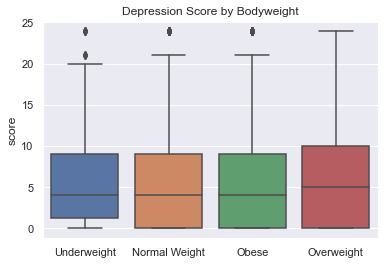

In [62]:
sns.boxplot(x='bmi', y='score', data=subset_df)
ax = plt.gca()
ax.set_xticklabels(['Underweight', 'Normal Weight', 'Obese', 'Overweight'])
ax.set_xlabel('')
plt.title("Depression Score by Bodyweight")

From the boxplots, we can point out that samples that are overweight have higher depression score(median and 75 percentile) while underweight have a higher 25 percentile compared to the rest of the boxplots. Thus, it present evidence to our hypothesis. 

### Relationship between Income and Depression Score

In [63]:
income_score = subset_df[['income', 'score']].copy()
income_score.corr()

,income,score
income,1.000000,-0.024318
score,-0.024318,1.000000


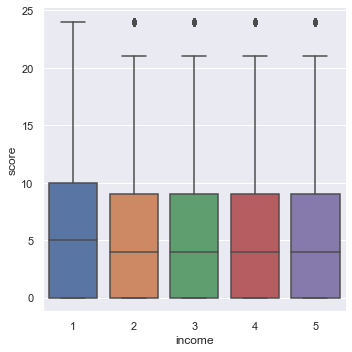

In [64]:
sns.catplot(x="income", y="score", kind="box", data=subset_df)

Our expections is that higher income will yield lower depression score. To test this, we wil use one way ANOVA to test for mean difference. **(One-way analysis of variance is a technique that can be used to compare whether two sample's means are significantly different or not.)**

In [65]:
# aggregate score by income groups, then conduct one way ANOVA
income_groups = subset_df.groupby('income').agg(list)['score']

scipy.stats.f_oneway(*income_groups)

F_onewayResult(statistic=5.035287571820111, pvalue=0.0004696961648013117)

We have a very small p-value, we have strong evidence that depression scores is not the same across all income groups. To further confirm this claim, we will conduct a pairwise Tukey's HSD test. **(Tukey's HSD test, is a single-step multiple comparison procedure and statistical test. It can be used to find means that are significantly different from each other.)**

In [66]:
print(pairwise_tukeyhsd(subset_df['score'], subset_df['income']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   -0.266 0.1907 -0.6003  0.0682  False
     1      3  -0.1709 0.5206 -0.4689  0.1271  False
     1      4  -0.3779 0.0152 -0.7077 -0.0482   True
     1      5  -0.3956 0.0003 -0.6559 -0.1354   True
     2      3   0.0952 0.9492 -0.2596  0.4499  False
     2      4  -0.1119 0.9308 -0.4937  0.2699  False
     2      5  -0.1296 0.8106 -0.4533  0.1941  False
     3      4  -0.2071 0.4899 -0.5576  0.1435  False
     3      5  -0.2248  0.202 -0.5109  0.0614  False
     4      5  -0.0177 0.9999 -0.3368  0.3014  False
----------------------------------------------------


It appears that the mean differences for (group 1 and 4) and (group 1 and 5) are statistically significant, while the others have quite similar mean depression scores.

### Relationship between Household and Depression Score

Household location is another potential predictor of mental health. Here, we expect that people who live in large urban areas are more likely to have mental health issues than people who live in rural areas due to their fast-paced lifestyles. We have 5 classes of household location. Here, we cast them into a binary variable of urban or rural.

In [67]:
subset_df['urban'] = subset_df['urbanrural'].apply(lambda x : x != 4)
rural_scores = subset_df[subset_df['urbanrural'] == 4]['score']
urban_scores = subset_df[subset_df['urbanrural'] != 4]['score']

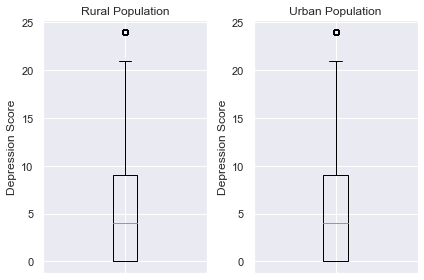

In [68]:
# display mental health score between urban and rural populations
f, a = plt.subplots(1,2)
a = a.flatten()
a[0].boxplot(rural_scores)
a[0].set_xticklabels("")
a[0].set_title('Rural Population')
a[0].set_ylabel('Depression Score')
a[1].boxplot(urban_scores)
a[1].set_xticklabels("")
a[1].set_ylabel('Depression Score')
a[1].set_title('Urban Population')
plt.tight_layout()

The boxplots above seems to contradicts our assumptions, rural groups seems to have higher depression score.

# Machine Learning

In [69]:
subset_df['score'].describe()

count    29046.000000
mean         6.260070
std          6.054101
min          0.000000
25%          0.000000
50%          4.000000
75%          9.000000
max         24.000000
Name: score, dtype: float64

In [70]:
print(subset_df['score'])

0         0.0
1         4.0
2         0.0
3         3.0
4         2.0
         ... 
31562    12.0
31563     8.0
31564     8.0
31565    12.0
31566    14.0
Name: score, Length: 29046, dtype: float64


In [71]:
subset_df.isna().any()

urbanrural    False
age           False
sex           False
edu           False
anx_ever      False
dep_ever      False
inscov        False
anx_freq      False
anx_level     False
dep_freq      False
dep_level     False
orient        False
marital       False
income        False
bmi           False
score         False
norm_score    False
mh_ever       False
lgbt          False
urban         False
dtype: bool

### Encoding Features

In [72]:
cols = ['age', 'income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital'] # features
cat_cols = ['income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital'] # categorical features
onehot = sklearn.preprocessing.OneHotEncoder()

##### Setting up dataframe for Regression Task

In [73]:
reg_df = subset_df[cols].copy() # copy all features into a new df so we do not mess up our dataset
E_reg_df = pd.DataFrame.sparse.from_spmatrix(onehot.fit_transform(reg_df[cat_cols])) # use one hot encoding for all categorical columns
E_reg_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


##### Setting up dataframe for Classification Task

In [74]:
clf_df = subset_df[cols].copy() # copy all features into a new df so we do not mess up our dataset
# copy first target variable. is the depression score > 0?
clf_df['mh_ever'] = subset_df['mh_ever'].copy() 
clf_df['score'] = subset_df['score'].copy()
# construct second target label. Is the depression score in the top 50%?
median_score = subset_df['score'].median()
clf_df['top50'] = clf_df['score'].apply(lambda x : x > median_score)


In [75]:
cat_df = pd.DataFrame.sparse.from_spmatrix(onehot.fit_transform(clf_df[cat_cols])) # use one hot encoding for all categorical columns
cat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


The onehot encoding converted our 8 categorical columns into 23. Since we only have one numerical feature (age), we will merge that with all the categorical ones to form our feature matrix. T

## Regression
In this section, we frame a regression task. We aim to directly predict depression score, which is a continuous variable. 

In [76]:
E_reg_df['age'] = reg_df['age'].copy()
E_reg_df['score'] = subset_df['score'].copy() #Use subset_df because reg_df does not have 'score' column

In [77]:
E_reg_df.isna().any()

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
age       True
score     True
dtype: bool

### Splitting Data and Target
* X = features
* Y = target

In [78]:
E_reg_df2= E_reg_df.dropna() #Remove Row with NA values
X = E_reg_df2.drop(columns='score',axis=1)

Y = E_reg_df2['score']



In [79]:
print(X)

         0    1    2    3    4    5    6    7    8    9  ...   14   15   16  \
0      0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
1      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
2      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
3      0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  1.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
29041  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29042  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  1.0  0.0  0.0   
29043  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29044  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29045  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   

        17   18   19   20   21   22   age  
0      

In [80]:
print(Y)

0         0.0
1         4.0
2         0.0
3         3.0
4         2.0
         ... 
29041     0.0
29042     0.0
29043     0.0
29044    24.0
29045     2.0
Name: score, Length: 26693, dtype: float64


### Splitting Training and Test data

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=150)

### Model Training

In [82]:
from xgboost import XGBRegressor
regressor = XGBRegressor()

In [83]:
# training the model
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### Evaluation

In [84]:
# prediction on Train Data

training_data_prediction = regressor.predict(X_train)

In [85]:
r2_train = metrics.r2_score(Y_train, training_data_prediction)


In [86]:
# R squared value

print('R Squared value = ', r2_train)

R Squared value =  0.17944673077141804


#### Compare the Actual Values and Predicted Values in a Plot

In [87]:
test_data_prediction = regressor.predict(X_test)

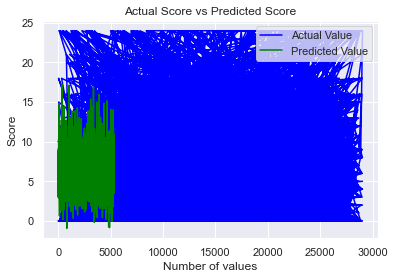

R Squared value =  -0.06087931118095802


In [88]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.title('Actual Score vs Predicted Score')
plt.xlabel('Number of values')
plt.ylabel('Score')
plt.legend()
plt.show()

r2_test = metrics.r2_score(Y_test, test_data_prediction)
print('R Squared value = ', r2_test)

We only managed to achieve an accuracy score of 20% at directly predicting depression score.
Due to the limitations of our depression score definition and the fact that most of our features are categorical based, this is expected.

## Classification
In this section, we frame a classification task. We split the dataset into score < 4.0 (median score) and score > 4.0 category, yielding a balanced classification task. We also introduce another classification task that predicts between score = 0 and score > 0, which is slightly unbalanced but is more meaningful in predicting whether people has any mental health condition than using median threshold.

In [89]:
cat_df['age']  = clf_df['age'].copy()

In [90]:
cat_df['target1'] = clf_df['mh_ever'].copy()
cat_df['target2'] = clf_df['top50'].copy()

In [91]:
cat_df.isna().any()

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
age         True
target1     True
target2     True
dtype: bool

In [92]:
cat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,age,target1,target2
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,85.0,False,False
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,39.0,True,False
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,42.0,False,False
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,32.0,True,False
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,85.0,True,False


In [93]:
cat_df['target1'].value_counts()

True     19391
False     7302
Name: target1, dtype: int64

In [94]:
cat_df.isnull().sum()

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
age        2353
target1    2353
target2    2353
dtype: int64

### Splitting the data and target
* x1 = features1
* x2 = features2
* y1 = target1
* y2 = target2

In [95]:
cat_df2= cat_df.dropna() #Remove Row with NA values
x1 = cat_df2.drop(columns=['target1', 'target2'],axis=1)
x2 = cat_df2.drop(columns=['target1', 'target2'],axis=1)
 
target1 = cat_df2['target1'].astype(int)
target2 = cat_df2['target2'].astype(int)
y1 = target1
y2 = target2

In [96]:
print(x1)

         0    1    2    3    4    5    6    7    8    9  ...   14   15   16  \
0      0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
1      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
2      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
3      0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  1.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
29041  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29042  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  1.0  0.0  0.0   
29043  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29044  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29045  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   

        17   18   19   20   21   22   age  
0      

In [97]:
print(x2)

         0    1    2    3    4    5    6    7    8    9  ...   14   15   16  \
0      0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
1      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
2      0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
3      0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0  0.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  1.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
29041  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29042  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  ...  1.0  0.0  0.0   
29043  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29044  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   
29045  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  0.0  0.0   

        17   18   19   20   21   22   age  
0      

In [98]:
print(y1)

0        0
1        1
2        0
3        1
4        1
        ..
29041    0
29042    0
29043    0
29044    1
29045    1
Name: target1, Length: 26693, dtype: int32


In [99]:
print(y2)

0        0
1        0
2        0
3        0
4        0
        ..
29041    0
29042    0
29043    0
29044    1
29045    0
Name: target2, Length: 26693, dtype: int32


### Splitting Training and Test data

In [100]:
# Splitting for target 1
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state=150)

In [101]:
# Splitting for target 2
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state=150)

In [102]:
x1.shape[1]


24

## Model Training

### Training For Target 1

In [103]:
print("Class Distribution (Positive to Negative): {:.1f}% / {:.1f}%".format(y1_train.mean() * 100, (1 - y1_train.mean()) * 100))

Class Distribution (Positive to Negative): 72.7% / 27.3%


#### Target 1 is highy unbalanced. However, it is significant since it's defined by whether a person will suffer from anxiety or depression at all.

In [104]:
import tensorflow as tf
inputs = tf.keras.Input(shape=(x1.shape[1],))
l = tf.keras.layers.Dense(1024, activation='relu')(inputs)
l = tf.keras.layers.Dense(1024, activation='relu')(l)
l = tf.keras.layers.Dense(1024, activation='relu')(l)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(l)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 256
epochs = 50

history = model.fit(
    x1_train,
    y1_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
67/67 [==============================] - 3s 37ms/step - loss: 0.8470 - accuracy: 0.6974 - auc: 0.4663 - val_loss: 0.6006 - val_accuracy: 0.7279 - val_auc: 0.5521 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5950 - accuracy: 0.7254 - auc: 0.5149 - val_loss: 0.5873 - val_accuracy: 0.7279 - val_auc: 0.5529 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5830 - accuracy: 0.7272 - auc: 0.5595 - val_loss: 0.5800 - val_accuracy: 0.7279 - val_auc: 0.5819 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5863 - accuracy: 0.7238 - auc: 0.5482 - val_loss: 0.5794 - val_accuracy: 0.7279 - val_auc: 0.5813 - lr: 0.0010
Epoch 5/50
67/67 [==============================] - 2s 33ms/step - loss: 0.5799 - accuracy: 0.7269 - auc: 0.5739 - val_loss: 0.5857 - val_accuracy: 0.7277 - val_auc: 0.5819 - lr: 0.0010
Epoch 6/50
67/67 [==============================] - 2s 33ms/step - los

67/67 [==============================] - 2s 33ms/step - loss: 0.5765 - accuracy: 0.7269 - auc: 0.5890 - val_loss: 0.5767 - val_accuracy: 0.7279 - val_auc: 0.5832 - lr: 1.0000e-05
Epoch 45/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5765 - accuracy: 0.7269 - auc: 0.5885 - val_loss: 0.5767 - val_accuracy: 0.7279 - val_auc: 0.5830 - lr: 1.0000e-05
Epoch 46/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5765 - accuracy: 0.7269 - auc: 0.5892 - val_loss: 0.5767 - val_accuracy: 0.7279 - val_auc: 0.5832 - lr: 1.0000e-06
Epoch 47/50
67/67 [==============================] - 2s 34ms/step - loss: 0.5765 - accuracy: 0.7269 - auc: 0.5892 - val_loss: 0.5767 - val_accuracy: 0.7279 - val_auc: 0.5831 - lr: 1.0000e-06
Epoch 48/50
67/67 [==============================] - 2s 33ms/step - loss: 0.5765 - accuracy: 0.7269 - auc: 0.5891 - val_loss: 0.5767 - val_accuracy: 0.7279 - val_auc: 0.5834 - lr: 1.0000e-06
Epoch 49/50
67/67 [==============================] - 2s 3

#### Model Evaluation For Target 1

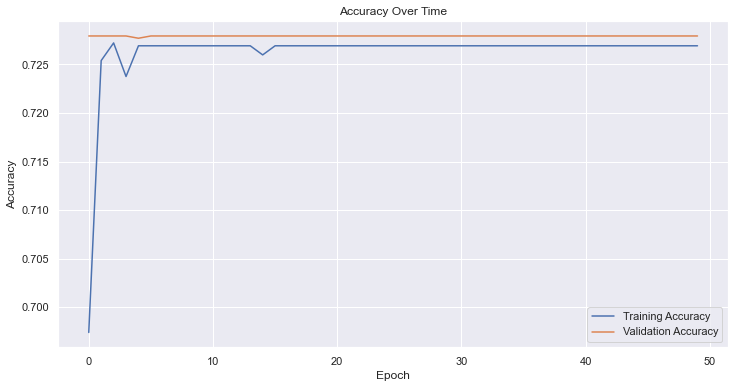

In [105]:
plt.figure(figsize=(12, 6))

plt.plot(range(epochs), history.history['accuracy'], label="Training Accuracy")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.title("Accuracy Over Time")

plt.show()

In [106]:
model.evaluate(x1_test, y1_test)

167/167 [==============================] - 1s 5ms/step - loss: 0.5793 - accuracy: 0.7237 - auc: 0.5923


[0.5792886018753052, 0.7237310409545898, 0.5922501683235168]

#### We have about 72% chance of predicting whether that person has had anxiety or depression. This is fairly decent performance given the features we have are mostly categorical variables.

### Training For Target 2

In [107]:
print("Class Distribution (Positive to Negative): {:.1f}% / {:.1f}%".format(y2_train.mean() * 100, (1 - y2_train.mean()) * 100))

Class Distribution (Positive to Negative): 47.9% / 52.1%


#### Target 2 is more balanced since we defined it as "if the mental health score is higher than the median". This variable will predict if the person has a higher than usual depression score.

In [108]:
inputs = tf.keras.Input(shape=(x2.shape[1],))
l = tf.keras.layers.Dense(1024, activation='relu')(inputs)
l = tf.keras.layers.Dense(1024, activation='relu')(l)
l = tf.keras.layers.Dense(1024, activation='relu')(l)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(l)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 1024
epochs = 100

history = model.fit(
    x2_train,
    y2_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
17/17 [==============================] - 2s 88ms/step - loss: 1.8133 - accuracy: 0.5054 - auc: 0.5081 - val_loss: 0.6909 - val_accuracy: 0.5203 - val_auc: 0.5597 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 1s 74ms/step - loss: 0.6939 - accuracy: 0.5106 - auc: 0.5160 - val_loss: 0.7057 - val_accuracy: 0.5203 - val_auc: 0.5595 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 1s 75ms/step - loss: 0.6952 - accuracy: 0.5265 - auc: 0.5218 - val_loss: 0.6926 - val_accuracy: 0.5203 - val_auc: 0.5606 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 1s 74ms/step - loss: 0.6914 - accuracy: 0.5272 - auc: 0.5337 - val_loss: 0.6895 - val_accuracy: 0.5526 - val_auc: 0.5610 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 1s 73ms/step - loss: 0.6897 - accuracy: 0.5432 - auc: 0.5445 - val_loss: 0.6878 - val_accuracy: 0.5462 - val_auc: 0.5605 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 1s 73ms/step

17/17 [==============================] - 1s 71ms/step - loss: 0.6846 - accuracy: 0.5522 - auc: 0.5703 - val_loss: 0.6867 - val_accuracy: 0.5505 - val_auc: 0.5614 - lr: 1.0000e-05
Epoch 45/100
17/17 [==============================] - 1s 72ms/step - loss: 0.6846 - accuracy: 0.5525 - auc: 0.5704 - val_loss: 0.6866 - val_accuracy: 0.5502 - val_auc: 0.5610 - lr: 1.0000e-05
Epoch 46/100
17/17 [==============================] - 1s 72ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5704 - val_loss: 0.6867 - val_accuracy: 0.5502 - val_auc: 0.5613 - lr: 1.0000e-05
Epoch 47/100
17/17 [==============================] - 1s 70ms/step - loss: 0.6846 - accuracy: 0.5524 - auc: 0.5704 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5614 - lr: 1.0000e-05
Epoch 48/100
17/17 [==============================] - 1s 70ms/step - loss: 0.6846 - accuracy: 0.5522 - auc: 0.5704 - val_loss: 0.6867 - val_accuracy: 0.5509 - val_auc: 0.5613 - lr: 1.0000e-05
Epoch 49/100
17/17 [==============================] -

Epoch 87/100
17/17 [==============================] - 1s 71ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5705 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5612 - lr: 1.0000e-09
Epoch 88/100
17/17 [==============================] - 1s 71ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5705 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5612 - lr: 1.0000e-09
Epoch 89/100
17/17 [==============================] - 1s 71ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5705 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5612 - lr: 1.0000e-09
Epoch 90/100
17/17 [==============================] - 1s 70ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5705 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5612 - lr: 1.0000e-10
Epoch 91/100
17/17 [==============================] - 1s 71ms/step - loss: 0.6846 - accuracy: 0.5521 - auc: 0.5705 - val_loss: 0.6867 - val_accuracy: 0.5507 - val_auc: 0.5612 - lr: 1.0000e-10
Epoch 92/100
17/17 [====================

#### Evaluation for Target 2

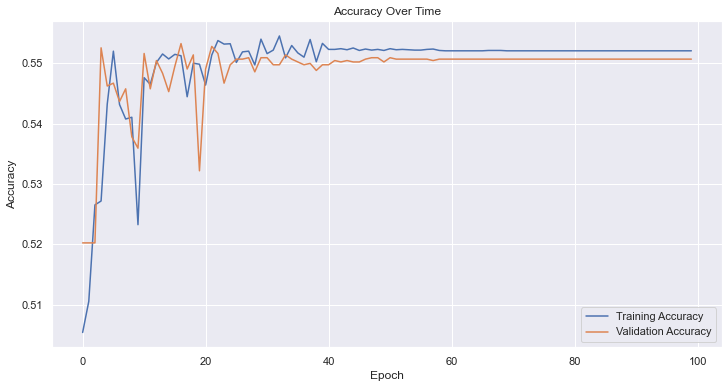

In [109]:
plt.figure(figsize=(12, 6))

plt.plot(range(epochs), history.history['accuracy'], label="Training Accuracy")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.title("Accuracy Over Time")

plt.show()

In [110]:
model.evaluate(x2_test, y2_test)

167/167 [==============================] - 1s 5ms/step - loss: 0.6849 - accuracy: 0.5544 - auc: 0.5678


[0.6849114894866943, 0.5544109344482422, 0.56782466173172]

#### In a more balanced problem, our highest test set accuracy dropped to around 55% with multi-layer neural network classifier. This is expected since our model will have a lower chance of hitting true positives. Our resulting model has a 55% accuracy in predicting whether a person has higher than usual depression score. 